# Detecting communities from graph signals on sequences of graphs

Here, we demonstrate some numerical experiments to demonstrate and push the bounds of the proposed community detection algorithm.

In [1]:
from lib import *

from random import choices, sample, randint, seed
seed(1776)
np.random.seed(1776)

import pandas as pd

from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png','pdf')

from cycler import cycler
plotcycle = cycler('linestyle', ['-','--','-','--','-','--']) + \
            cycler('marker', ['^','x','o','^','x','o']) + \
            cycler('color', ['tab:blue','tab:orange','tab:green','tab:red','tab:cyan','tab:purple'])
plt.rcParams['axes.prop_cycle'] = plotcycle

## Model order selection

We set the graph parameters here, with $N=500$ nodes, $k=3$ communities, and intracluster edge probability of $p=4\log N/N$.
The values of $\gamma$ that dictate $q=\gamma p$ range from $0.1$ to $0.9$.
The excitation function generates white noise, and the system function draws a graph from the specified PPM and returns the filter
$$\mathcal{H}=\left(\mathbf{I}-\alpha\mathbf{L}\right)^5$$
for $\alpha=\frac{1}{\log N(4 + 4\gamma)}$.

In [2]:
# model parameters
N = 500
ms = [500, 1000, 5000]
reference_m = 10000
k = 3
gammas = np.linspace(0.1, 0.9, 5)

# round things to have equally sized communities
sizes = list(N//k * np.ones(k).astype(int))
N = sum(sizes)
true_labels = label_nodes(sizes)

p = 4*np.log(N)/N

# store output here
threshold_results = {}
mdl_results = {}
for g in gammas:
    threshold_results[g] = {}
    mdl_results[g] = {}

# system-generating functions
excitation = lambda : np.random.randn(N) # returns an excitation signal
shift = lambda E : laplacian(bernoulli_adjacency_matrix(E))
filt = lambda L, alpha : np.linalg.matrix_power((np.eye(N) - alpha*L), 5)
system = lambda E, alpha : filt(shift(E), alpha) # returns a filter matrix

For each value of $\gamma$, we form a new graph model, as well as recalculate the filter coefficient $\alpha$.
The spectrum for large $m$ is calculated, and then the optimal threshold for that spectrum is used as a reference for the naive threshold estimator.
The MDL and naive threshold estimators are then applied for multiple values of $m$.

In [3]:
for gamma in gammas:
    
    q = gamma*p
    E = expected_sbm_matrix(true_labels, sbm_pp_parameters(k, p, q))
    alpha = 1/(np.log(N)*(4+4*gamma))
    system_ = lambda : system(E, alpha)
    
    expected_spectrum = np.linalg.eigvalsh(empirical_covariance(system_, excitation, reference_m))
    threshold = 1/2*(expected_spectrum[N-k-1] + expected_spectrum[N-k])
    
    for m in ms:
        
        threshold_results[gamma][m] = list()
        mdl_results[gamma][m] = list()

        for i in range(10):
        
            print(f'gamma {gamma} m {m} run {i}\r', end='')
    
            C = empirical_covariance(system_, excitation, m)
            threshold_results[gamma][m].append(order_selection(C, threshold))
            mdl_results[gamma][m].append(mdl_order_selection(C, m))
            
        threshold_results[gamma][m] = np.mean(threshold_results[gamma][m])
        mdl_results[gamma][m] = np.mean(mdl_results[gamma][m])

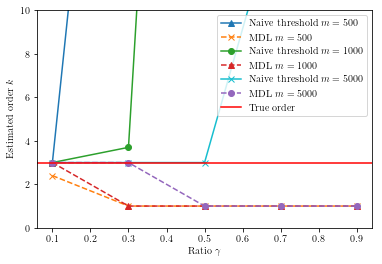

In [4]:
for m in ms:
    plt.plot(gammas, [threshold_results[g][m] for g in gammas], label=rf'Naive threshold $m={m}$')
    plt.plot(gammas, [mdl_results[g][m] for g in gammas], label=rf'MDL $m={m}$')
plt.axhline(y=k, xmin=0.0, xmax=1.0, color='r', label='True order')
plt.ylim(0,10)
plt.legend()
plt.xlabel(r'Ratio $\gamma$')
plt.ylabel(r'Estimated order $k$')
plt.savefig('figs/order-estimation.pdf')

The naive threshold estimator tends to overestimate the model order, so we truncate the y-axis of this plot for visibility.

## Colored excitation

We set the graph paremeters here.
$N=500$ nodes are used, with $m$ ranging from $10$ to $1000$ on a logarithmic scale.
There are $k=2$ communities with a fixed $\gamma=0.3$.
The graph filter is the same as before.

In [5]:
# model parameters
N = 500
m = 1000
ms = np.round(np.logspace(1, np.log10(m), 9, base=10)).astype(int)
k = 2
gamma = 0.3

# round things to have equally sized communities
sizes = list(N//k * np.ones(k).astype(int))
N = sum(sizes)
true_labels = label_nodes(sizes)

p = 4*np.log(N)/N
q = gamma*p
E = expected_sbm_matrix(true_labels, sbm_pp_parameters(k, p, q))
alpha = 1/(np.log(N)*(4+4*gamma))

# store output here
colored_error_rates = {}

# system-generating functions
shift = lambda E : laplacian(bernoulli_adjacency_matrix(E))
filt = lambda L, alpha : np.linalg.matrix_power((np.eye(N) - alpha*L), 5)
system = lambda : filt(shift(E), alpha) # returns a filter matrix

The system excitations are created by coloring white noise.
The base function is ```white_color```, which simply returns a white Gaussian vector.
This excitation can then be modified with ```colored_function```, which takes a matrix $\mathbf{M}$ and returns a new function that multiplies $\mathbf{M}$ by a white Gaussian vector.

The adversarial color, for example, is created using a weighted sum of $\mathbf{V}_{noise}\mathbf{V}_{noise}^\top$ and $\mathbf{V}_{good}\mathbf{V}_{good}^\top$, which correspond to the lower $N-k$ and upper $k$ eigenvectors of the expected adjacency matrix, respectively.

In [6]:
# building the functions to use for colored excitation

# white input
white_color = lambda : np.random.randn(N)

# everything else : specify a matrix M to color Gaussian noise with
# this returns a new excitation function that takes no input
colored_function = lambda M : lambda : M @ white_color()

## adversarial/friendly input
_, V = np.linalg.eigh(E)
V_noise = V[:, 0:N-k]
V_good = V[:, N-k:]
VV_noise = V_noise @ V_noise.T
VV_good = V_good @ V_good.T

colors = ['white', 'diagonal', 'adversarial', 
          #'friendly',
          'Wishart 10', 'Wishart 100']

Each data point is evaluated 10 times and averaged to yield the plotted values.

In [7]:
for color in colors:
    
    colored_error_rates[color] = list()
    
    for i in range(10):
        
        if color == 'white':
            excitation = white_color
        elif color == 'diagonal':
            excitation = colored_function(np.diag(np.random.rand(N)))
        elif color == 'adversarial':
            excitation = colored_function(0.9*VV_noise + 0.1*VV_good)
        #elif color == 'friendly':
        #    excitation = colored_function(0.1*VV_noise + 0.9*VV_good)
        elif color == 'Wishart 10':
            M = np.cov(np.random.randn(N,10))
            W, V = np.linalg.eigh(M)
            M = V @ np.diag(np.sqrt(W, where=(W>0))) @ V.T
            excitation = colored_function(M)
        elif color == 'Wishart 100':
            M = np.cov(np.random.randn(N,100))
            W, V = np.linalg.eigh(M)
            M = V @ np.diag(np.sqrt(W, where=(W>0))) @ V.T
            excitation = colored_function(M)
            
        print(f'{color} run {i}\r', end='')
            
        Cs = empirical_covariance_multiple(system, excitation, ms)
        pred_labels = [partition_recovery(C, k) for C in Cs]
        errs = [fraction_mislabeled_nodes(true_labels, pred) for pred in pred_labels]
        
        colored_error_rates[color].append(errs)
        
    colored_error_rates[color] = np.mean(colored_error_rates[color], axis=0)

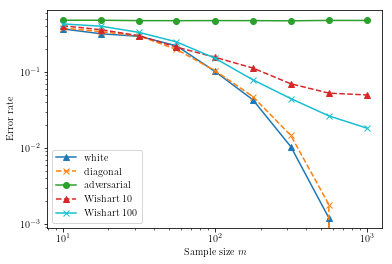

In [8]:
for color in colors:
    plt.loglog(ms, colored_error_rates[color], label=rf'{color}')
plt.legend()
plt.xlabel(rf'Sample size $m$')
plt.ylabel(r'Error rate')
plt.savefig('figs/colored-excitation.pdf')

## Graph sequence independence

Once again, we define the graph parameters here. Note that $\gamma$ here is specifically chosen, via a bit of simple algebra, to be at the detectability limit.
This highlights the fact that our algorithm can leverage the observation of many graphs to successfully perform the community detection task even when standard detectability requirements are barely met.

In [9]:
# model parameters
N = 500
m = 2000
ms = np.round(np.logspace(1, np.log10(m), 9, base=10)).astype(int)
k = 2

# round things to have equally sized communities
sizes = list(N//k * np.ones(k).astype(int))
N = sum(sizes)
true_labels = label_nodes(sizes)

p = 4*np.log(N)/N
gamma_threshold = 1 + 1 / (4 * np.log(N)) - 1 / 2 * np.sqrt(4 / np.log(N) + 1 / (4 * (np.log(N) ** 2)))
gamma_hi = gamma_threshold
q = gamma_hi*p

E = expected_sbm_matrix(true_labels, sbm_pp_parameters(k, p, q))
alpha = 1/(np.log(N)*(4+4*gamma_hi))

# store output here
dependent_error_rates = {}

The graph-drawing process is implemented as a generator, created using the Bernoulli parameter $p$

In [10]:
def bernoulli_shift_generator(E, p):
    # draw a new adjacency matrix with probability p at each step
    A = bernoulli_adjacency_matrix(E)
    while True:
        yield A
        A = choices([A, bernoulli_adjacency_matrix(E)],
                    weights=[1-p, p],
                    k=1)[0]
        
def independent_shift_generator(E):
    while True:
        yield bernoulli_adjacency_matrix(E)
            
def constant_shift_generator(E):
    A = bernoulli_adjacency_matrix(E)
    while True:
        yield A

# system-generating functions
excitation = lambda : np.random.randn(N)
shift = lambda E : laplacian(bernoulli_adjacency_matrix(E))
filt = lambda L, alpha : np.linalg.matrix_power((np.eye(N) - alpha*L), 5)

policies = ['constant', r'bernoulli $p=0.1$', r'bernoulli $p=0.5$', 'independent']

Each graph sampling policy gets 10 runs, with a new initial state for each run.

In [11]:
for policy in policies:
    
    dependent_error_rates[policy] = list()
    
    for i in range(10):
        
        print(f'{policy} run {i}\r',end='')
        
        if policy == 'constant':
            gen = constant_shift_generator(E)
        elif policy == 'bernoulli $p=0.1$':
            gen = bernoulli_shift_generator(E, 0.1)
        elif policy == 'bernoulli $p=0.5$':
            gen = bernoulli_shift_generator(E, 0.5)
        elif policy == 'independent':
            gen = independent_shift_generator(E)
            
        system = lambda : filt(laplacian(next(gen)), alpha)
        
        Cs = empirical_covariance_multiple(system, excitation, ms)
        pred_labels = [partition_recovery(C, k) for C in Cs]
        errs = [fraction_mislabeled_nodes(true_labels, pred) for pred in pred_labels]
        
        dependent_error_rates[policy].append(errs)
        
    dependent_error_rates[policy] = np.mean(dependent_error_rates[policy], axis=0)

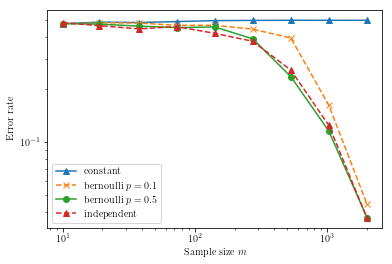

In [12]:
for policy in policies:
    plt.loglog(ms, dependent_error_rates[policy], label=rf'{policy}')
plt.legend()
plt.xlabel(rf'Sample size $m$')
plt.ylabel(r'Error rate')
plt.savefig('figs/graph-sequence.pdf')

## Number of communities



In [15]:
# model parameters
n = 50
m = 1000
ms = np.round(np.logspace(1, np.log10(m), 9, base=10)).astype(int)
ks = [2,4,8]
gamma_base = 0.3

# share p for all runs
p = 4*np.log(2*n)/(2*n)
q_fixed = gamma_base * p

# store output here
communities_overlap_scores_fix_q = {}
communities_error_rates_fix_q = {}
communities_overlap_scores_adjust_q = {}
communities_error_rates_adjust_q = {}

overlap_std_fix_q = {}
error_std_fix_q = {}
overlap_std_adjust_q = {}
error_std_adjust_q = {}

# system generating functions
shift = lambda E : laplacian(bernoulli_adjacency_matrix(E))
filt = lambda L, alpha : np.linalg.matrix_power((np.eye(*L.shape) - alpha*L), 5)

For the "adjusted $q$" experiments, we modify the $\gamma$ parameter with $k$ to make the "signal to noise ratio" approximately constant.
Specifically,
$$\gamma(k)=\frac{\gamma(2)}{k-1}$$
keeps the number of "interference edges" at each cluster constant.
Thus, when $k=2$, the adjusted and fixed $q$ experiments are the same.

In [22]:
print('Adjust value for q')

for k in ks:

    communities_overlap_scores_adjust_q[k] = list()
    communities_error_rates_adjust_q[k] = list()
    
    overlap_std_adjust_q[k] = list()
    error_std_adjust_q[k] = list()
    
    sizes = list(n * np.ones(k).astype(int))
    N = sum(sizes)
    true_labels = label_nodes(sizes)

    excitation = lambda : np.random.randn(N)
    
    gamma = gamma_base / (k-1)
    #p = 4*np.log(N)/N
    q = gamma*p
    E = expected_sbm_matrix(true_labels, sbm_pp_parameters(k, p, q))
    alpha = 1/(np.log(N)*(4+4*gamma))
    
    system = lambda : filt(shift(E), alpha)

    for i in range(20):
        
        print(f'k {k} run {i}\r',end='')
        
        Cs = empirical_covariance_multiple(system, excitation, ms)
        pred_labels = [partition_recovery(C, k) for C in Cs]
        overlaps = [overlap_score(true_labels, pred) for pred in pred_labels]
        errs = [fraction_mislabeled_nodes(true_labels, pred) for pred in pred_labels]
        
        communities_overlap_scores_adjust_q[k].append(overlaps)
        communities_error_rates_adjust_q[k].append(errs)
        
    overlap_std_adjust_q[k] = np.std(communities_overlap_scores_adjust_q[k], axis=0)
    error_std_adjust_q[k] = np.std(communities_error_rates_adjust_q[k], axis=0)
        
    communities_overlap_scores_adjust_q[k] = np.mean(communities_overlap_scores_adjust_q[k], axis=0)
    communities_error_rates_adjust_q[k] = np.mean(communities_error_rates_adjust_q[k], axis=0)

Adjust value for q


In [17]:
print('Fix value for q')

for k in ks[1:]:

    communities_overlap_scores_fix_q[k] = list()
    communities_error_rates_fix_q[k] = list()
    
    overlap_std_fix_q[k] = list()
    error_std_fix_q[k] = list()
    
    sizes = list(n * np.ones(k).astype(int))
    N = sum(sizes)
    true_labels = label_nodes(sizes)

    excitation = lambda : np.random.randn(N)
    
    q = q_fixed
    E = expected_sbm_matrix(true_labels, sbm_pp_parameters(k, p, q))
    alpha = 1/(np.log(N)*(4+4*gamma_base))
    
    system = lambda : filt(shift(E), alpha)

    for i in range(20):
        
        print(f'k {k} run {i}\r',end='')
        
        Cs = empirical_covariance_multiple(system, excitation, ms)
        pred_labels = [partition_recovery(C, k) for C in Cs]
        overlaps = [overlap_score(true_labels, pred) for pred in pred_labels]
        errs = [fraction_mislabeled_nodes(true_labels, pred) for pred in pred_labels]
        
        communities_overlap_scores_fix_q[k].append(overlaps)
        communities_error_rates_fix_q[k].append(errs)
        
    overlap_std_fix_q[k] = np.std(communities_overlap_scores_fix_q[k], axis=0)
    error_std_fix_q[k] = np.std(communities_error_rates_fix_q[k], axis=0)
        
    communities_overlap_scores_fix_q[k] = np.mean(communities_overlap_scores_fix_q[k], axis=0)
    communities_error_rates_fix_q[k] = np.mean(communities_error_rates_fix_q[k], axis=0)

Fix value for q


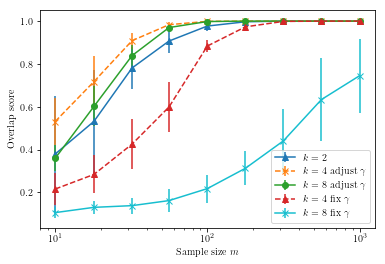

In [23]:
plt.errorbar(ms, communities_overlap_scores_adjust_q[2], overlap_std_adjust_q[2], label=rf'$k=2$')
for k in ks[1:]:
    plt.errorbar(ms, communities_overlap_scores_adjust_q[k], overlap_std_adjust_q[k], label=rf'$k={k}$ adjust $\gamma$')
for k in ks[1:]:
    plt.errorbar(ms, communities_overlap_scores_fix_q[k], overlap_std_fix_q[k], label=rf'$k={k}$ fix $\gamma$')
plt.legend()
plt.xlabel(r'Sample size $m$')
plt.ylabel(r'Overlap score')
plt.xscale('log')
plt.savefig('figs/communities-overlap.pdf')

In [19]:
# the lonely remnants of a plot of the error rates
#for k in ks:
#    plt.loglog(ms, communities_error_rates[k], label=rf'$k={k}$')
#plt.legend()
#plt.xlabel(r'Sample size $m$')
#plt.ylabel(r'Error rate')
#plt.savefig('figs/communities.pdf')

## Clustering stock data



Here, we demonstrate the full pipeline of analysis for stock data from the S&P 100 (obtained from [Yahoo! Finance](https://finance.yahoo.com/)).
We've already pulled the data inta a pandas dataframe here.

In [3]:
df = pd.read_pickle('stock_data/stock_dataframe.pkl')

# stock names are columns of dataframe
ticks = list(df.columns)

# calculate log-return and normalize
signals = df.values
log_return = np.log(signals[1:,:]/signals[0:-1,:])
log_return = (log_return - np.mean(log_return, axis=0)) / np.std(log_return, axis=0)

M = log_return.shape[0]

### Initial look

First, we apply the order selection and community detection algorithm to the entire dataset, to obtain a "ground truth."

In [4]:
C = np.cov(log_return.T)
true_k = mdl_order_selection(C, M)

labels = partition_recovery(C, true_k)

D = {}

for i in range(true_k):
    D[i] = list()
    
for l,t in zip(labels, ticks):
    D[l].append(t)

_, v = np.linalg.eigh(C)
v = v[:,-true_k:]

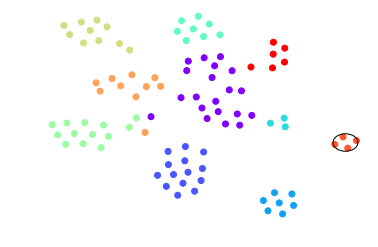

In [5]:
embedding = TSNE(n_components=2, perplexity=20).fit_transform(v)

fig, ax = plt.subplots()

ax.scatter(embedding[:,0].T, embedding[:,1].T, c=labels, cmap='rainbow')

special_ticks = D[np.random.randint(true_k)]
special_points = np.array([e for l,e in zip(ticks, embedding) if l in special_ticks])

special_center = np.mean(special_points, axis=0)
special_radius = np.max(np.linalg.norm(special_points - special_center, axis=1))

ax.add_patch(plt.Circle(special_center, 1.1*special_radius, color='k', fill=False))

ax.axis('off')
fig.savefig('figs/stock-tsne.pdf')

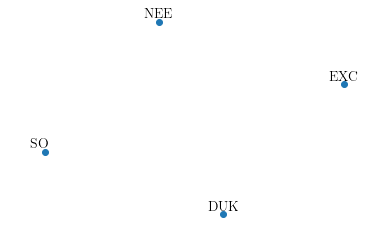

In [6]:
special_points -= np.min(special_points, axis=0)
special_points /= np.max(special_points, axis=0)

plt.scatter(special_points[:,0].T, special_points[:,1].T)

for l,e in zip(special_ticks, special_points):
    plt.text(*(e-[0.05,-0.02]), l, fontsize=14)
    
plt.axis('off')
plt.savefig('figs/stock-tsne-zoomed.pdf')

In [7]:
pd.DataFrame.from_dict(D, orient='index')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,ACN,BA,CAT,CSCO,DD,DHR,EMR,F,FDX,GM,HON,IBM,INTC,MMM,ORCL,QCOM,TXN,UNP,UPS,UTX
1,AIG,ALL,AXP,BAC,BK,BLK,C,COF,GS,JPM,MET,MS,USB,WFC,None,None,None,None,None,None
2,COP,CVX,HAL,KMI,OXY,SLB,XOM,None,None,None,None,None,None,None,None,None,None,None,None,None
3,GD,LMT,RTN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,AAPL,AMZN,FB,GOOG,MA,MSFT,PYPL,V,None,None,None,None,None,None,None,None,None,None,None,None
5,ABBV,ABT,AGN,AMGN,BIIB,BMY,CELG,GILD,JNJ,LLY,MDT,MRK,PFE,None,None,None,None,None,None,None
6,CL,KHC,KO,MCD,MDLZ,MO,PEP,PG,PM,SBUX,None,None,None,None,None,None,None,None,None,None
7,COST,CVS,HD,LOW,NKE,SPG,TGT,UNH,WBA,WMT,None,None,None,None,None,None,None,None,None,None
8,DUK,EXC,NEE,SO,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
9,CMCSA,DIS,FOX,GE,T,VZ,None,None,None,None,None,None,None,None,None,None,None,None,None,None


MDL + Community Detection yields $k=10$ communities in the dataset, tabulated above.
Now, we see how well we can recover this when we use fewer samples.

In [8]:
ms = np.round(np.linspace(len(labels), M, 10)).astype(int)
ms = np.append(ms, M)

results = list()
results_known_k = list()
orders_contiguous = list()
orders_scrambled = list()

# contiguous sampling
for m in ms:

    err_list = list()
    err_known_k_list = list()
    k_list = list()

    for i in range(50):
        
        print(f'm {m} run {i}\r',end='')

        idx = randint(0,M-m)

        C = np.cov(log_return[idx:idx+m].T)
        k = mdl_order_selection(C, m)
        labels_pred = partition_recovery(C, k)
        labels_pred_known_k = partition_recovery(C, true_k)
        err_list.append(fraction_mislabeled_nodes(labels, labels_pred))
        err_known_k_list.append(fraction_mislabeled_nodes(labels, labels_pred_known_k))
        k_list.append(k)

    results.append(np.mean(err_list))
    results_known_k.append(np.mean(err_known_k_list))
    orders_contiguous.append(np.mean(k_list))

# random sampling
for m in ms:

    k_list = list()

    for _ in range(50):

        idx = np.random.choice(M, size=m, replace=False)

        C = np.cov(log_return[idx].T)
        k = mdl_order_selection(C, m)
        k_list.append(k)

    orders_scrambled.append(np.mean(k_list))

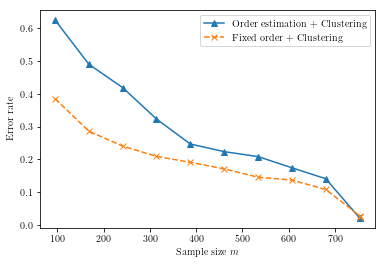

In [9]:
plt.plot(ms, results, label='Order estimation + Clustering')
plt.plot(ms, results_known_k, label='Fixed order + Clustering')
plt.legend()
plt.xlabel(r'Sample size $m$')
plt.ylabel(r'Error rate')
plt.savefig('figs/stock-error.pdf')

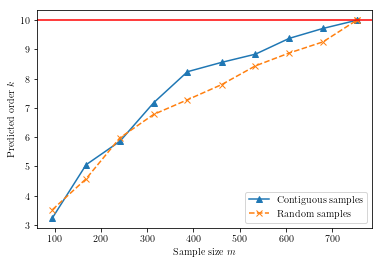

In [10]:
plt.plot(ms, orders_contiguous, label='Contiguous samples')
plt.plot(ms, orders_scrambled, label='Random samples')
plt.legend()
plt.axhline(y=true_k, xmin = 0.0, xmax = 1.0, color = 'r', label = 'True order')
plt.xlabel(r'Sample size $m$')
plt.ylabel(r'Predicted order $k$')
plt.savefig('figs/stock-order.pdf')

Note that the "error rate" is only with respect to the communities determined by using all of the data.
This serves to demonstrate that as more samples are taken, the community detection algorithm "smoothly" recovers the communities.

Next, we demonstrate the consistency of our algorithm on the stock dataset.
This is done by considering a fixed number of samples, say $m\approx 200$.
We then divide the dataset into contiguous blocks of length $m$, and apply the community detection algorithm ($k=10$) to each set of samples.
If the algorithm is consistent, the pairwise classification error rates between them should be small.

In [31]:
m = M//4
k = 10

sample_sets = [log_return[i*m:(i+1)*m] for i in range(M//m)]
#idx_permute = np.random.permutation(M)
#idxs = [idx_permute[i*m:(i+1)*m] for i in range(M//m)]
#sample_sets = [log_return[idx] for idx in idxs]
Cs = [np.cov(s.T) for s in sample_sets]

labels_pred = [partition_recovery(C, k) for C in Cs]
labels_pred.append(np.random.randint(0, k, len(labels)))

pairwise_errors = np.zeros([M//m + 1, M//m + 1])
pairwise_overlaps = np.zeros([M//m + 1, M//m + 1])

for i in range(0,M//m + 1):
    for j in range(i,M//m + 1):
        err = fraction_mislabeled_nodes(labels_pred[i], labels_pred[j])
        ovr = overlap_score(labels_pred[i], labels_pred[j])
        pairwise_errors[i, j] = err
        pairwise_errors[j, i] = err
        pairwise_overlaps[i, j] = ovr
        pairwise_overlaps[j, i] = ovr

array([[1.  , 0.52, 0.47, 0.42, 0.08],
       [0.52, 1.  , 0.67, 0.56, 0.09],
       [0.47, 0.67, 1.  , 0.55, 0.05],
       [0.42, 0.56, 0.55, 1.  , 0.  ],
       [0.08, 0.09, 0.05, 0.  , 1.  ]])

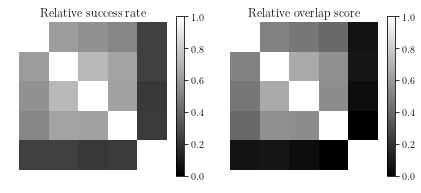

In [33]:
plt.subplot(121)
plt.imshow(1-pairwise_errors, cmap='gray', vmin=0.0, vmax=1.0)
plt.colorbar(shrink=0.6)
plt.axis('off')
plt.title('Relative success rate')

plt.subplot(122)
plt.imshow(pairwise_overlaps, cmap='gray', vmin=0.0, vmax=1.0)
plt.colorbar(shrink=0.6)
plt.axis('off')
plt.title('Relative overlap score')

plt.tight_layout()

plt.savefig('figs/stock-consistency.pdf')

np.round(pairwise_overlaps, decimals=2)

In this matrix, each row/column corresponds to a contiguous block of samples.
Light cells correspond to high overlap score (notice the diagonal always has an overlap score of 1) and dark cells correspond to low overlap.